In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Erwood_NPC1_HEK293T"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [3]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")
scoreset = scoreset.assign(CHROM=scoreset.CHROM.astype(str),
                           POSITION=scoreset.POSITION.astype(str),
                           REF=scoreset.REF.astype(str),
                           ALT=scoreset.ALT.astype(str))

In [4]:
if scoreset.duplicated(subset=['CHROM',"POSITION",'REF','ALT']).any():
    scoreset_dedup = scoreset.groupby(['CHROM',"POSITION",'REF','ALT']).agg({'score': 'mean'})
else:
    scoreset_dedup = scoreset.set_index(['CHROM',"POSITION",'REF','ALT'])['score']

In [5]:
scoredata = scoreset.set_index(['CHROM',"POSITION",'REF','ALT'])
scoreset = pd.merge(scoreset_dedup,
                    scoredata.loc[:,list(set(scoredata.columns) - {'score','Unadjusted Function Score'})].drop_duplicates(),
                    left_index=True,right_index=True,how='left',validate='one_to_one')

In [6]:
scoreset.shape[0]

969

In [7]:
scoreset.head()

score author_transcript Protein Annotation  \
CHROM POSITION REF ALT                                                  
18    23536837 A   T    0.954726         NM_000271             L1027L   
                   G    0.999139         NM_000271             L1027L   
                   C    0.963492         NM_000271             L1027L   
      23536836 C   T    0.936084         NM_000271             G1028S   
                   G    0.953889         NM_000271             G1028R   

                       Wild type Base  nonsense  \
CHROM POSITION REF ALT                            
18    23536837 A   T                T     False   
                   G                T     False   
                   C                T     False   
      23536836 C   T                G     False   
                   G                G     False   

                                                             refseq_id  \
CHROM POSITION REF ALT                                                   
18    23536837 A   T    NPC1:NM_000271:exon21:c.T3081A:p.L1027L:Select   
                   G    NPC1:NM_000271:exon21:c.T3081C:p.L1027L:Select   
                   C    NPC1:NM_000271:exon21:c.T3081G:p.L1027L:Select   
      23536836 C   T    NPC1:NM_000271:exon21:c.G3082A:p.G1028S:Select   
                   G    NPC1:NM_000271:exon21:c.G3082C:p.G1028R:Select   

                        synonymous      hgvs_pro SPE Classification  \
CHROM POSITION REF ALT                                                
18    23536837 A   T          True  p.Leu1027Leu         Functional   
                   G          True  p.Leu1027Leu         Functional   
                   C          True  p.Leu1027Leu         Functional   
      23536836 C   T         False  p.Gly1028Ser         Functional   
                   G         False  p.Gly1028Arg         Functional   

                       Consequence Clinvar_SIG     start   CDS  \
CHROM POSITION REF ALT                                           
18    23536837 A   T    synonymous         NaN  23536836  3081   
                   G    synonymous         NaN  23536836  3081   
                   C    synonymous         NaN  23536836  3081   
      23536836 C   T      missense         NaN  23536835  3082   
                   G      missense         NaN  23536835  3082   

                                                 id  CADD_phred Edited Base  
CHROM POSITION REF ALT                                                       
18    23536837 A   T    chr18-23536836-23536837-A-T         NaN           A  
                   G    chr18-23536836-23536837-A-G         NaN           C  
                   C    chr18-23536836-23536837-A-C         NaN           G  
      23536836 C   T    chr18-23536835-23536836-C-T         NaN           A  
                   G    chr18-23536835-23536836-C-G       11.22           C

In [8]:
if 'author_transcript' not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [9]:
clinvar_nuc_summaries = clinvar_df[clinvar_df.index.isin(scoreset.index)].groupby(level=list(range(4)),).apply(mapping_utils.summarize_clinvar_group)

In [10]:
clinvar_nuc_summaries.index.rename(['CHROM',"POSITION",'REF','ALT'],inplace=True)

In [11]:
scoreset_w_clinvar = pd.merge(scoreset,clinvar_nuc_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="many_to_one",
                            suffixes=("","_clinvar"))

In [12]:
scoreset_w_clinvar.shape[0]

969

In [13]:
scoreset_w_clinvar.head()

score author_transcript Protein Annotation  \
CHROM POSITION REF ALT                                                  
18    23536837 A   T    0.954726         NM_000271             L1027L   
                   G    0.999139         NM_000271             L1027L   
                   C    0.963492         NM_000271             L1027L   
      23536836 C   T    0.936084         NM_000271             G1028S   
                   G    0.953889         NM_000271             G1028R   

                       Wild type Base  nonsense  \
CHROM POSITION REF ALT                            
18    23536837 A   T                T     False   
                   G                T     False   
                   C                T     False   
      23536836 C   T                G     False   
                   G                G     False   

                                                             refseq_id  \
CHROM POSITION REF ALT                                                   
18    23536837 A   T    NPC1:NM_000271:exon21:c.T3081A:p.L1027L:Select   
                   G    NPC1:NM_000271:exon21:c.T3081C:p.L1027L:Select   
                   C    NPC1:NM_000271:exon21:c.T3081G:p.L1027L:Select   
      23536836 C   T    NPC1:NM_000271:exon21:c.G3082A:p.G1028S:Select   
                   G    NPC1:NM_000271:exon21:c.G3082C:p.G1028R:Select   

                        synonymous      hgvs_pro SPE Classification  \
CHROM POSITION REF ALT                                                
18    23536837 A   T          True  p.Leu1027Leu         Functional   
                   G          True  p.Leu1027Leu         Functional   
                   C          True  p.Leu1027Leu         Functional   
      23536836 C   T         False  p.Gly1028Ser         Functional   
                   G         False  p.Gly1028Arg         Functional   

                       Consequence Clinvar_SIG     start   CDS  \
CHROM POSITION REF ALT                                           
18    23536837 A   T    synonymous         NaN  23536836  3081   
                   G    synonymous         NaN  23536836  3081   
                   C    synonymous         NaN  23536836  3081   
      23536836 C   T      missense         NaN  23536835  3082   
                   G      missense         NaN  23536835  3082   

                                                 id  CADD_phred Edited Base  \
CHROM POSITION REF ALT                                                        
18    23536837 A   T    chr18-23536836-23536837-A-T         NaN           A   
                   G    chr18-23536836-23536837-A-G         NaN           C   
                   C    chr18-23536836-23536837-A-C         NaN           G   
      23536836 C   T    chr18-23536835-23536836-C-T         NaN           A   
                   G    chr18-23536835-23536836-C-G       11.22           C   

                        num_p_lp  num_b_lb  num_conflicting  num_VUS  \
CHROM POSITION REF ALT                                                 
18    23536837 A   T         NaN       NaN              NaN      NaN   
                   G         0.0       1.0              0.0      0.0   
                   C         NaN       NaN              NaN      NaN   
      23536836 C   T         NaN       NaN              NaN      NaN   
                   G         NaN       NaN              NaN      NaN   

                                                   clinvar_names  \
CHROM POSITION REF ALT                                             
18    23536837 A   T                                         NaN   
                   G    NM_000271.5(NPC1):c.3081T>C (p.Leu1027=)   
                   C                                         NaN   
      23536836 C   T                                         NaN   
                   G                                         NaN   

                        clinvar_records  clinvar_spliceAI_max  
CHROM POSITION REF ALT                                         
18    2353683

In [14]:
scoreset_w_clinvar[scoreset_w_clinvar.num_p_lp > 0].shape

(37, 23)

In [15]:
scoreset_w_clinvar[scoreset_w_clinvar.num_b_lb > 0].shape

(51, 23)

# Add gnomAD annotations

In [16]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [17]:
scoreset[scoreset.index.isin(gnomAD_df.index)].shape[0], scoreset.shape[0]

(125, 969)

In [18]:
gnomAD_matches = gnomAD_df[(gnomAD_df.index.isin(scoreset.index)) & \
                            (gnomAD_df.Feature_base.isin(set(Ensembl_transcript_stable_ids).union(set((AUTHOR_TRANSCRIPT,)))))].sort_values(by='AC',ascending=False)

gnomAD_matches_unique = gnomAD_matches[~gnomAD_matches.index.duplicated(keep='first')]

In [19]:
gnomAD_matches_unique.index.rename(['CHROM',"POSITION",'REF','ALT'],inplace=True)

In [20]:
gnomAD_matches_unique.head()

ID  QUAL FILTER   AC        AF  \
CHROM POSITION REF ALT                                            
18    23539875 C   T     rs34302553 -10.0   PASS  818  0.000560   
      23536736 A   G     rs80358259 -10.0   PASS  750  0.000513   
      23536811 G   A     rs28942104 -10.0   PASS  168  0.000115   
      23534487 C   T    rs767795351 -10.0   PASS  150  0.000103   
      23536722 T   C    rs747903100 -10.0   PASS  120  0.000082   

                                                                      vep  \
CHROM POSITION REF ALT                                                      
18    23539875 C   T    T|missense_variant|MODERATE|NPC1|ENSG000001414...   
      23536736 A   G    G|downstream_gene_variant|MODIFIER|RMC1|ENSG00...   
      23536811 G   A    A|downstream_gene_variant|MODIFIER|RMC1|ENSG00...   
      23534487 C   T    T|downstream_gene_variant|MODIFIER|RMC1|ENSG00...   
      23536722 T   C    C|downstream_gene_variant|MODIFIER|RMC1|ENSG00...   

                        index Allele       Consequence    IMPACT SYMBOL  \
CHROM POSITION REF ALT                                                    
18    23539875 C   T    13086      T  missense_variant  MODERATE   NPC1   
      23536736 A   G    11614      G  missense_variant  MODERATE   NPC1   
      23536811 G   A    11679      A  missense_variant  MODERATE   NPC1   
      23534487 C   T    10580      T  missense_variant  MODERATE   NPC1   
      23536722 T   C    11606      C  missense_variant  MODERATE   NPC1   

                                   Gene Feature_type          Feature  \
CHROM POSITION REF ALT                                                  
18    23539875 C   T    ENSG00000141458   Transcript  ENST00000269228   
      23536736 A   G               4864   Transcript      NM_000271.5   
      23536811 G   A               4864   Transcript      NM_000271.5   
      23534487 C   T               4864   Transcript      NM_000271.5   
      23536722 T   C    ENSG00000141458   Transcript  ENST00000269228   

                               BIOTYPE   EXON  INTRON  \
CHROM POSITION REF ALT                                  
18    23539875 C   T    protein_coding  18/25     NaN   
      23536736 A   G    protein_coding  21/25     NaN   
      23536811 G   A    protein_coding  21/25     NaN   
      23534487 C   T    protein_coding  23/25     NaN   
      23536722 T   C    protein_coding  21/25     NaN   

                                               HGVSc  \
CHROM POSITION REF ALT                                 
18    23539875 C   T    ENST00000269228.10:c.2731G>A   
      23536736 A   G           NM_000271.5:c.3182T>C   
      23536811 G   A           NM_000271.5:c.3107C>T   
      23534487 C   T           NM_000271.5:c.3550G>A   
      23536722 T   C    ENST00000269228.10:c.3196A>G   

                                                 HGVSp  cDNA_position  \
CHROM POSITION REF ALT                                                  
18    23539875 C   T     ENSP00000269228.4:p.Gly911Ser           2894   
      23536736 A   G          NP_000262.2:p.Ile1061Thr           3345   
      23536811 G   A          NP_000262.2:p.Thr1036Met           3270   
      23534487 C   T          NP_000262.2:p.Val1184Met           3713   
      23536722 T   C    ENSP00000269228.4:p.Thr1066Ala           3359   

                        CDS_position  Protein_position Amino_acids   Codons  \
CHROM POSITION REF ALT                                                        
18    23539875 C   T            2731               911         G/S  Ggc/Agc   
      23536736 A   G            3182              1061         I/T  aTa/aCa   
      23536811 G   A            3107              1036         T/M  aCg/aTg   
      23534487 C   T            3550              1184         V/M  Gtg/Atg   
      23536722 T   C            3196              1066         T/A  Acc/Gcc   

                        ALLELE_NUM  DISTANCE  STRAND  FLAGS VARIANT_CLASS  \
CHROM POSITION REF ALT                           

In [21]:
gnomAD_matches.shape, gnomAD_matches_unique.shape

((316, 56), (125, 56))

In [22]:
gnomAD_matches_unique.index.has_duplicates

False

In [23]:
gnomAD_matches_unique.shape, scoreset_w_clinvar.shape

((125, 56), (969, 23))

In [24]:
scoreset_w_clinvar.index.duplicated().any()

np.False_

In [25]:
gnomAD_matches_unique.index.duplicated().any()

np.False_

In [26]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_matches_unique,
                                        left_index=True,right_index=True,how="left",validate="one_to_one")#.reset_index()

In [27]:
scoreset_processed.shape

(969, 79)

In [28]:
scoreset_processed.head()

score author_transcript Protein Annotation  \
CHROM POSITION REF ALT                                                  
18    23536837 A   T    0.954726         NM_000271             L1027L   
                   G    0.999139         NM_000271             L1027L   
                   C    0.963492         NM_000271             L1027L   
      23536836 C   T    0.936084         NM_000271             G1028S   
                   G    0.953889         NM_000271             G1028R   

                       Wild type Base  nonsense  \
CHROM POSITION REF ALT                            
18    23536837 A   T                T     False   
                   G                T     False   
                   C                T     False   
      23536836 C   T                G     False   
                   G                G     False   

                                                             refseq_id  \
CHROM POSITION REF ALT                                                   
18    23536837 A   T    NPC1:NM_000271:exon21:c.T3081A:p.L1027L:Select   
                   G    NPC1:NM_000271:exon21:c.T3081C:p.L1027L:Select   
                   C    NPC1:NM_000271:exon21:c.T3081G:p.L1027L:Select   
      23536836 C   T    NPC1:NM_000271:exon21:c.G3082A:p.G1028S:Select   
                   G    NPC1:NM_000271:exon21:c.G3082C:p.G1028R:Select   

                        synonymous    hgvs_pro_x SPE Classification  \
CHROM POSITION REF ALT                                                
18    23536837 A   T          True  p.Leu1027Leu         Functional   
                   G          True  p.Leu1027Leu         Functional   
                   C          True  p.Leu1027Leu         Functional   
      23536836 C   T         False  p.Gly1028Ser         Functional   
                   G         False  p.Gly1028Arg         Functional   

                       Consequence_x Clinvar_SIG     start   CDS  \
CHROM POSITION REF ALT                                             
18    23536837 A   T      synonymous         NaN  23536836  3081   
                   G      synonymous         NaN  23536836  3081   
                   C      synonymous         NaN  23536836  3081   
      23536836 C   T        missense         NaN  23536835  3082   
                   G        missense         NaN  23536835  3082   

                                                 id  CADD_phred Edited Base  \
CHROM POSITION REF ALT                                                        
18    23536837 A   T    chr18-23536836-23536837-A-T         NaN           A   
                   G    chr18-23536836-23536837-A-G         NaN           C   
                   C    chr18-23536836-23536837-A-C         NaN           G   
      23536836 C   T    chr18-23536835-23536836-C-T         NaN           A   
                   G    chr18-23536835-23536836-C-G       11.22           C   

                        num_p_lp  num_b_lb  num_conflicting  num_VUS  \
CHROM POSITION REF ALT                                                 
18    23536837 A   T         NaN       NaN              NaN      NaN   
                   G         0.0       1.0              0.0      0.0   
                   C         NaN       NaN              NaN      NaN   
      23536836 C   T         NaN       NaN              NaN      NaN   
                   G         NaN       NaN              NaN      NaN   

                                                   clinvar_names  \
CHROM POSITION REF ALT                                             
18    23536837 A   T                                         NaN   
                   G    NM_000271.5(NPC1):c.3081T>C (p.Leu1027=)   
                   C                                         NaN   
      23536836 C   T                                         NaN   
                   G                                         NaN   

                        clinvar_records  clinvar_spliceAI_max   ID  QUAL  \
CHROM POSITION REF ALT                             

In [29]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [30]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [31]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.AF > 0 and r.spliceAI_scores <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [32]:
INVERT_DATA = False

sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

if INVERT_DATA:
    sample_data = {k : -1 * v for k,v in sample_data.items()}


In [33]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 28
B/LB: 51
gnomAD: 124
synonymous: 56


(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object))

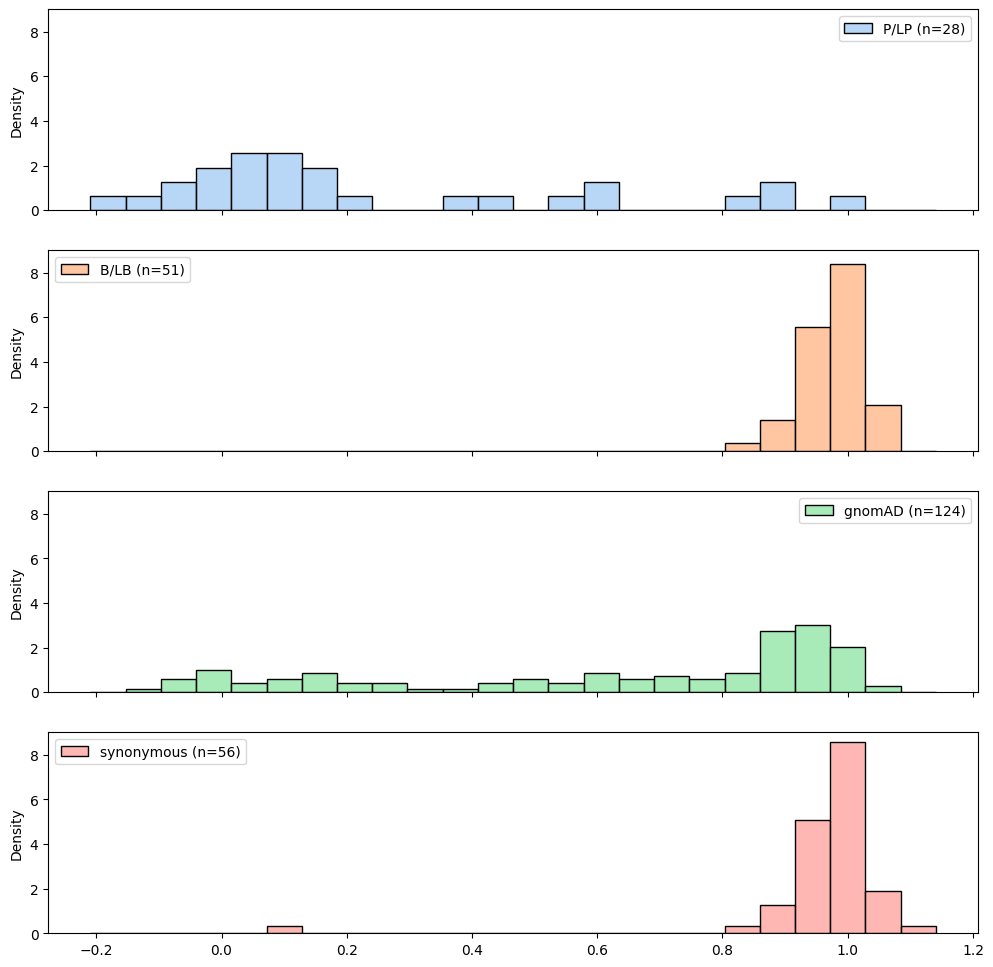

In [34]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [35]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                            *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)